# In this notebook you can choose between analytical (w41) vs automatic (w42) gradients.
## Start by setting up global stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import jax.numpy as jnp
from jax import grad

In [2]:
# Global parameters
N = 128  # no. data points
N_epoch = 1000  # max no. epochs/iterations before stopping
noise_std = 0.1  # standard deviation of noise
lmbda = 0.001  # Ridge hyperparameter lambda
theta_tol = 1e-7  # theta tolerance for stopping iteration when |theta_new - theta_old| <= theta_tol
rng_seed = 2023  # seed for generating psuedo-random values
HEATMAP_CMAP = "coolwarm"  # colormap for seaborn heatmap plots

epoch_iters = range(N_epoch)  # for plotting

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10 * x + 2 * x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # design matrix

# Create class for OLS and Ridge, with both analytical and automatical gradiant calculations

In [3]:
class OLS:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.N = y.size
        self.automatic_grad = grad(self.cost_func)

    def cost_func(self, theta):
        return 1 / self.N * jnp.sum((self.y - self.X @ theta)**2)

    def analytic_grad(self, theta):
        return 2 / self.N * self.X.T @ (self.X @ theta - self.y)


class Ridge(OLS):
    def __init__(self, X, y, lmbda):
        super().__init__(X, y)
        self.lmbda = lmbda

    def cost_func(self, theta):
        return 1 / self.N * jnp.sum((self.y - self.X @ theta)**2) + lmbda * jnp.sum(jnp.abs(theta))

    def analytic_grad(self, theta):
        return 2 / self.N * (self.X.T @ (self.X @ theta - self.y) + lmbda * theta)


In [4]:
# Initialize objects used for the whole task
ols = OLS(X, y)
ridge = Ridge(X, y, lmbda)

########### Differentiation method choice ################
# grad_ols = ols.analytic_grad  # use analytical expression
# grad_ridge = ridge.analytic_grad  # ...
grad_ols = ols.automatic_grad  # use jax automatic differentiation
grad_ridge = ridge.automatic_grad  # ...

In [5]:
######## Print values ###########

# own OLS inversion
theta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Hessian matrices 
H_ols = 2 / N * X.T @ X
eig_ols, _ = np.linalg.eig(H_ols)
max_eig_ols = 1 / max(eig_ols)

print(f"OLS:\n1/lambda_max={max_eig_ols:.3f}")
print(f"2/lambda_max={2 * max_eig_ols:.3f}")
print(f"Theta from inversion={theta_ols.ravel()}")

# own ridge inversion
XT_X = X.T @ X
I = np.identity(np.shape(XT_X)[0])
lmbda_I = lmbda * I
theta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)

# Hessian matrix
H = 2 / N * XT_X + 2 * lmbda_I
eig_ridge, _ = np.linalg.eig(H)
max_eig_ridge = 1 / max(eig_ridge)

print(f"\nRidge:\n1/lambda_max={max_eig_ridge:.3f}")
print(f"2/lambda_max={2 * max_eig_ridge:.3f}")
print(f"Theta from inversion={theta_ridge.ravel()}")

OLS:
1/lambda_max=0.390
2/lambda_max=0.779
Theta from inversion=[ 4.63898721 -7.93024817]

Ridge:
1/lambda_max=0.389
2/lambda_max=0.779
Theta from inversion=[ 4.63843602 -7.92924881]


# 1. Plain gradient descent (GD) convergence with fixed learning rate

OLS theta=[ 4.6389856 -7.9302454], error=2.832e-02, converged after 165 iterations.
Ridge theta=[ 4.6336465 -7.920854 ], error=4.088e-02, converged after 166 iterations.


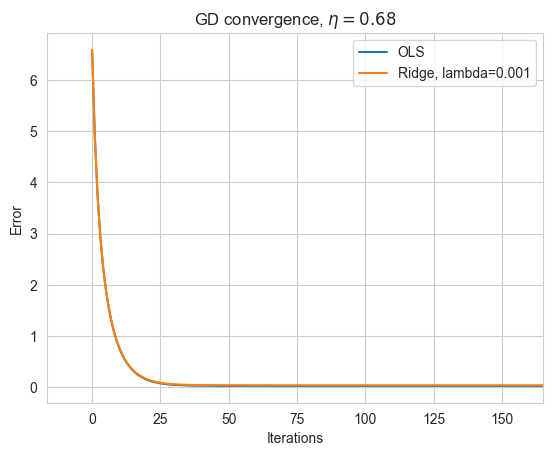

In [6]:
# Parameters
learn_rate = 0.68  # learning rate

# store the theta errors for each iter
errors_gd_ols = np.zeros(N_epoch)
errors_gd_ridge = np.zeros_like(errors_gd_ols)

# begin with theta guess
theta_gd_ols = rng.standard_normal((2, 1))
theta_gd_ridge = theta_gd_ols.copy()

# OLS loop
theta_gd_ols_prev = np.zeros(theta_gd_ols.shape)
for epoch_ols in epoch_iters:
    theta_gd_ols_prev = theta_gd_ols.copy()

    # Plain gradient descent: update theta
    theta_gd_ols -= learn_rate * grad_ols(theta_gd_ols)

    # Store MSE as error
    errors_gd_ols[epoch_ols] = ols.cost_func(theta_gd_ols)

    # Convergence test
    if all(abs(theta_gd_ols - theta_gd_ols_prev) <= theta_tol):
        errors_gd_ols[epoch_ols:] = errors_gd_ols[epoch_ols]
        break

# Ridge loop
theta_gd_ridge_prev = np.zeros(theta_gd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_gd_ridge_prev = theta_gd_ridge.copy()

    # Plain gradient descent: update theta
    theta_gd_ridge -= learn_rate * grad_ridge(theta_gd_ridge)

    # Store MSE as error
    errors_gd_ridge[epoch_ridge] = ridge.cost_func(theta_gd_ridge)

    # Convergence test
    if all(abs(theta_gd_ridge - theta_gd_ridge_prev) <= theta_tol):
        errors_gd_ridge[epoch_ridge:] = errors_gd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gd_ols, label="OLS")
plt.plot(epoch_iters, errors_gd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"GD convergence, $\eta={learn_rate:.2f}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gd_ols.ravel()}, error={errors_gd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_gd_ridge.ravel()}, error={errors_gd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

The choice of fixed learning rate $\eta=0.68$ gave the fastest convergence with the same error value. This is still below $2/\lambda_{max}=0.77$. 

# 2. Gradient descent with momentum/memory (GDM) convergence with fixed learning rate

OLS theta=[ 4.638991  -7.9302554], error=2.832e-02, converged after 63 iterations.
Ridge theta=[ 4.633648 -7.920856], error=4.088e-02, converged after 75 iterations.


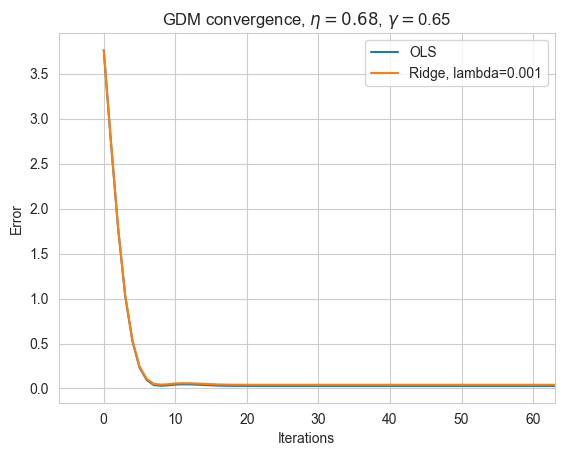

In [7]:
# Parameters
learn_rate = learn_rate  # learning rate, use same as for GD
momentum_rate = 0.65  # momentum rate

# store the theta errors for each iter
errors_gdm_ols = np.zeros(N_epoch)
errors_gdm_ridge = np.zeros_like(errors_gdm_ols)

# begin with theta guess
theta_gdm_ols = rng.standard_normal((2, 1))
theta_gdm_ridge = theta_gdm_ols.copy()

# OLS loop
theta_gdm_ols_prev = np.zeros(theta_gdm_ols.shape)
change = 0
for epoch_ols in epoch_iters:
    theta_gdm_ols_prev = theta_gdm_ols.copy()

    # GDM change 
    new_change = learn_rate * grad_ols(theta_gdm_ols) + momentum_rate * change

    # Update values
    theta_gdm_ols -= new_change
    change = new_change.copy()

    # Store MSE as error
    errors_gdm_ols[epoch_ols] = ols.cost_func(theta_gdm_ols)

    # Convergence test
    if all(abs(theta_gdm_ols - theta_gdm_ols_prev) <= theta_tol):
        errors_gdm_ols[epoch_ols:] = errors_gdm_ols[epoch_ols]
        break

# Ridge loop
theta_gdm_ridge_prev = np.zeros(theta_gdm_ridge.shape)
change = 0
for epoch_ridge in epoch_iters:
    theta_gdm_ridge_prev = theta_gdm_ridge.copy()

    # GDM change 
    new_change = learn_rate * grad_ridge(theta_gdm_ridge) + momentum_rate * change

    # Update values
    theta_gdm_ridge -= new_change
    change = new_change.copy()

    # Store MSE as error
    errors_gdm_ridge[epoch_ridge] = ridge.cost_func(theta_gdm_ridge)

    # Convergence test
    if all(abs(theta_gdm_ridge - theta_gdm_ridge_prev) <= theta_tol):
        errors_gdm_ridge[epoch_ridge:] = errors_gdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gdm_ols, label="OLS")
plt.plot(epoch_iters, errors_gdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"GDM convergence, $\eta={learn_rate:.2f}$, $\gamma=${momentum_rate:.2f}")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gdm_ols.ravel()}, error={errors_gdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_gdm_ridge.ravel()}, error={errors_gdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

Clearly using momentum provides a bit faster convergence, although (at least for this example) the same error. This choice of momentum rate $\gamma\approx0.65$ gave the fastest convergence. I would think that for other more complex examples adding momentum would be even more beneficial than this was.

# 3. Stochastic gradient descent (SGD) with replacement convergence and scaling learning rate

OLS theta=[ 4.638973  -7.9302235], error=2.832e-02, converged after 75 epochs.
Ridge theta=[ 4.638973  -7.9302235], error=4.088e-02, converged after 75 epochs.


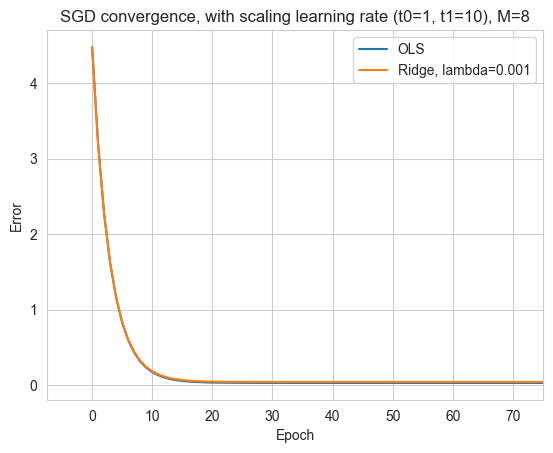

In [12]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches

# Learning schedule parameters
t0 = 1
t1 = 10


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time."""
    return t0 / (t + t1)


# store the theta errors for each iter
errors_sgd_ols = np.zeros(N_epoch)
errors_sgd_ridge = np.zeros_like(errors_sgd_ols)

# begin with theta guess
theta_sgd_ols = rng.standard_normal((2, 1))
theta_sgd_ridge = theta_sgd_ols.copy()

# OLS loop
theta_sgd_ols_prev = np.zeros(theta_sgd_ols.shape)
for epoch_ols in epoch_iters:
    theta_sgd_ols_prev = theta_sgd_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent on the random batch
        learn_rate_i = learning_schedule(epoch_ols * m + i)
        gradient = 1/M * grad_ols(theta_sgd_ols)

        # Update theta
        theta_sgd_ols -= learn_rate * gradient

    # Store MSE as error for each epoch iteration
    errors_sgd_ols[epoch_ols] = ols.cost_func(theta_sgd_ols)

    # Convergence test
    if all(abs(theta_sgd_ols - theta_sgd_ols_prev) <= theta_tol):
        errors_sgd_ols[epoch_ols:] = errors_sgd_ols[epoch_ols]
        break

# Ridge loop
theta_sgd_ridge_prev = np.zeros(theta_sgd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_sgd_ridge_prev = theta_sgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent on the random batch
        learn_rate_i = learning_schedule(epoch_ridge * m + i)
        gradient = 1/M* grad_ridge(theta_sgd_ridge)

        # Update theta
        theta_sgd_ridge -= learn_rate * gradient

    # Store MSE as error for each epoch iteration
    errors_sgd_ridge[epoch_ridge] = ridge.cost_func(theta_sgd_ridge)

    # Convergence test
    if all(abs(theta_sgd_ridge - theta_sgd_ridge_prev) <= theta_tol):
        errors_sgd_ridge[epoch_ols:] = errors_sgd_ridge[epoch_ols]
        break

# Plot errors as function of epoch iteration
plt.plot(epoch_iters, errors_sgd_ols, label="OLS")
plt.plot(epoch_iters, errors_sgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Epoch")
plt.ylabel(r"Error")
plt.title(f"SGD convergence, with scaling learning rate ({t0=}, {t1=}), {M=}")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_sgd_ols.ravel()}, error={errors_sgd_ols[-1]:.3e}, converged after {epoch_ols} epochs.")
print(f"Ridge theta={theta_sgd_ols.ravel()}, error={errors_sgd_ridge[-1]:.3e}, converged after {epoch_ridge} epochs.")

Here increasing the hyperparameter $M$ provides much faster runtime (faster epochs), but also provides slower convergence. On my desktop pc $M=1$ runs within a few seconds and provides convergence after only a few epochs. Even running so much faster than GD and GDM, the error is almost identical.

# 3. Stochastic gradient descent with momentum (SGDM) with replacement and scaling learning rate

OLS theta=[ 4.6389875 -7.9302487], error=2.832e-02, converged after 8 epochs.
Ridge theta=[ 4.6389875 -7.9302487], error=4.088e-02, converged after 9 epochs.


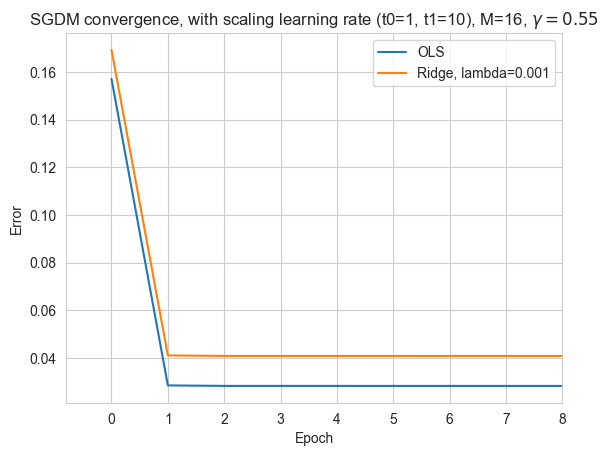

In [10]:
# Parameters
M = 16  # size of each minibatch
m = int(N / M)  # number of minibatches
momentum_rate = 0.55  # momentum rate

# Learning schedule parameters
t0 = 1
t1 = 10


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time."""
    return t0 / (t + t1)


# store the theta errors for each iter
errors_sgdm_ols = np.zeros(N_epoch)
errors_sgdm_ridge = np.zeros_like(errors_sgdm_ols)

# begin with theta guess
theta_sgdm_ols = rng.standard_normal((2, 1))
theta_sgdm_ridge = theta_sgdm_ols.copy()

# OLS loop
theta_sgdm_ols_prev = np.zeros(theta_sgdm_ols.shape)
change = 0
for epoch_ols in epoch_iters:
    theta_sgdm_ols_prev = theta_sgdm_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        gradient = grad_ols(theta_sgdm_ols)
        learn_rate_i = learning_schedule(epoch_ols * m + i)
        new_change = learn_rate * gradient + momentum_rate * change

        # Update values
        theta_sgdm_ols -= new_change
        change = new_change.copy()

    # Store MSE as error for each epoch iteration
    errors_sgdm_ols[epoch_ols] = ols.cost_func(theta_sgdm_ols)

    # Convergence test
    if all(abs(theta_sgdm_ols - theta_sgdm_ols_prev) <= theta_tol):
        errors_sgdm_ols[epoch_ols:] = errors_sgdm_ols[epoch_ols]
        break

# Ridge loop
theta_sgdm_ridge_prev = np.zeros(theta_sgdm_ridge.shape)
change = 0
for epoch_ridge in epoch_iters:
    theta_sgdm_ridge_prev = theta_sgdm_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        learn_rate_i = learning_schedule(epoch_ridge * m + i)
        gradient = grad_ridge(theta_sgdm_ridge)
        new_change = learn_rate * gradient + momentum_rate * change

        # Update values
        theta_sgdm_ridge -= new_change
        change = new_change.copy()

    # Store MSE as error for each epoch iteration
    errors_sgdm_ridge[epoch_ridge] = ridge.cost_func(theta_sgdm_ridge)

    # Convergence test
    if all(abs(theta_sgdm_ridge - theta_sgdm_ridge_prev) <= theta_tol):
        errors_sgdm_ridge[epoch_ridge:] = errors_sgdm_ridge[epoch_ridge]
        break

# Plot errors as function of epoch iteration
plt.plot(epoch_iters, errors_sgdm_ols, label="OLS")
plt.plot(epoch_iters, errors_sgdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Epoch")
plt.ylabel(r"Error")
plt.title(f"SGDM convergence, with scaling learning rate ({t0=}, {t1=}), {M=}, $\gamma={momentum_rate}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_sgdm_ols.ravel()}, error={errors_sgdm_ols[-1]:.3e}, converged after {epoch_ols} epochs.")
print(f"Ridge theta={theta_sgdm_ols.ravel()}, error={errors_sgdm_ridge[-1]:.3e}, converged after {epoch_ridge} epochs.")

The runtime is faster than SGD and has the same error with around the same epochs for convergence. This is extremely faster than all the previous methods, at least on my pc. Here the momentum rate $\gamma\approx0.55$ was the best value.

 # 4. Tuning the learning rate with Adagrad

### Adagrad GD

OLS theta=[ 4.6389856 -7.9302454], error=2.832e-02, converged after 206 iterations.
Ridge theta=[ 4.6336465 -7.920854 ], error=4.088e-02, converged after 207 iterations.


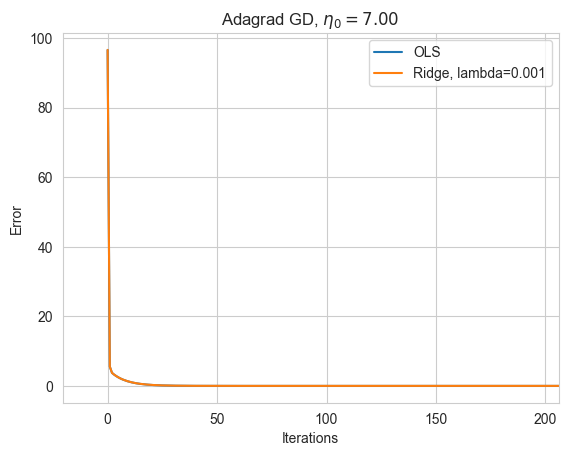

In [262]:
# Parameters
learn_rate = 7  # starting learning rate
delta = theta_tol  # small value for numerical stability  

# store the theta errors for each iter
errors_agd_ols = np.zeros(N_epoch)
errors_agd_ridge = np.zeros_like(errors_agd_ols)

# begin with theta guess
theta_agd_ols = rng.standard_normal((2, 1))
theta_agd_ridge = theta_agd_ols.copy()

# OLS loop
theta_agd_ols_prev = np.zeros(theta_agd_ols.shape)
r = 0
for epoch_ols in epoch_iters:
    theta_agd_ols_prev = theta_agd_ols.copy()

    # Plain gradient descent: update theta
    gradient = grad_ols(theta_agd_ols)
    r += gradient * gradient  
    theta_agd_ols -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale the learning rate with r

    # Store MSE as error
    errors_agd_ols[epoch_ols] = ols.cost_func(theta_agd_ols)

    # Convergence test
    if all(abs(theta_agd_ols - theta_agd_ols_prev) <= theta_tol):
        errors_agd_ols[epoch_ols:] = errors_agd_ols[epoch_ols]
        break

# Ridge loop
theta_agd_ridge_prev = np.zeros(theta_agd_ridge.shape)
r = 0
for epoch_ridge in epoch_iters:
    theta_agd_ridge_prev = theta_agd_ridge.copy()

    # Plain gradient descent: update theta
    gradient = grad_ridge(theta_agd_ridge)
    r += gradient * gradient
    theta_agd_ridge -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale the learning rate with r

    # Store MSE as error
    errors_agd_ridge[epoch_ridge] = ridge.cost_func(theta_agd_ridge)

    # Convergence test
    if all(abs(theta_agd_ridge - theta_agd_ridge_prev) <= theta_tol):
        errors_agd_ridge[epoch_ridge:] = errors_agd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_agd_ols, label="OLS")
plt.plot(epoch_iters, errors_agd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"Adagrad GD, $\eta_0={learn_rate:.2f}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_agd_ols.ravel()}, error={errors_agd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(f"Ridge theta={theta_agd_ridge.ravel()}, error={errors_agd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

The convergence varies from each run to run, but the overall best starting learning rate $\eta_0\approx 7$ was the fastest to converge. Overall this is slower converging than GD with fixed learning rate, but it seems the error drops way faster with Adagrad.

### Adagrad GDM

OLS theta=[-0.54732794 -1.9643344 ], error=7.361e+00, converged after 999 iterations.
Ridge theta=[-0.54692906 -1.9634669 ], error=7.361e+00, converged after 999 iterations.


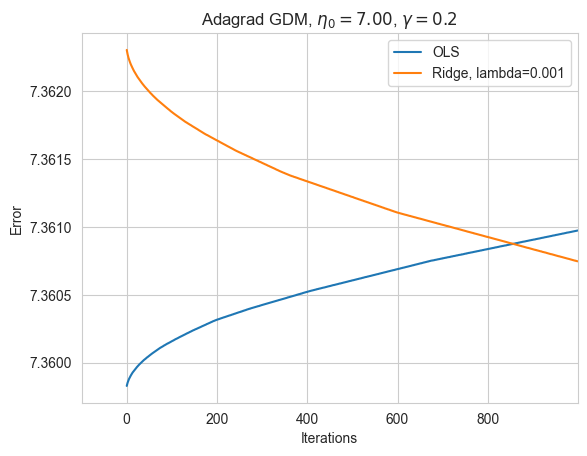

In [263]:
# Parameters
learn_rate = 7  # starting learning rate
momentum_rate = 0.2
delta = theta_tol  # small value for numerical stability  

# store the theta errors for each iter
errors_agdm_ols = np.zeros(N_epoch)
errors_agdm_ridge = np.zeros_like(errors_agdm_ols)

# begin with theta guess
theta_agdm_ols = rng.standard_normal((2, 1))
theta_agdm_ridge = theta_agdm_ols.copy()

# OLS loop
theta_agdm_ols_prev = np.zeros(theta_agdm_ols.shape)
change = 0
r = 0
for epoch_ols in epoch_iters:
    theta_agdm_ols_prev = theta_agdm_ols.copy()
    
    # Gradient
    gradient = grad_ols(theta_agdm_ols)
    r += gradient * gradient  
        
    # GDM change, scale the learning rate with r
    new_change = learn_rate / (delta + np.sqrt(r)) * gradient  * grad_ols(theta_gdm_ols) + momentum_rate * change 
    
    # Update values
    theta_agdm_ols -= new_change  
    change = new_change.copy()
    
    # Store MSE as error
    errors_agdm_ols[epoch_ols] = ols.cost_func(theta_agdm_ols)

    # Convergence test
    if all(abs(theta_agdm_ols - theta_agdm_ols_prev) <= theta_tol):
        errors_agdm_ols[epoch_ols:] = errors_agdm_ols[epoch_ols]
        break

# Ridge loop
theta_agdm_ridge_prev = np.zeros(theta_agdm_ridge.shape)
r = 0
for epoch_ridge in epoch_iters:
    theta_agdm_ridge_prev = theta_agdm_ridge.copy()

    # Gradient
    gradient = grad_ridge(theta_agdm_ridge)
    r += gradient * gradient  
        
    # GDM change, scale the learning rate with r
    new_change = learn_rate / (delta + np.sqrt(r)) * gradient  * grad_ridge(theta_gdm_ridge) + momentum_rate * change 
    
    # Update values
    theta_agdm_ridge -= new_change  
    change = new_change.copy()

    # Store MSE as error
    errors_agdm_ridge[epoch_ridge] = ridge.cost_func(theta_agdm_ridge)

    # Convergence test
    if all(abs(theta_agdm_ridge - theta_agdm_ridge_prev) <= theta_tol):
        errors_agdm_ridge[epoch_ridge:] = errors_agdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_agdm_ols, label="OLS")
plt.plot(epoch_iters, errors_agdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"Adagrad GDM, $\eta_0={learn_rate:.2f}$, $\gamma={momentum_rate}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_agdm_ols.ravel()}, error={errors_agdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(f"Ridge theta={theta_agdm_ridge.ravel()}, error={errors_agdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")